## Carry out linear inverse modeling on supplied data 
<br>

<b>Primary Author:</b>  Meg D. Fowler, CIRES/NOAA PSD <br>
<b>Date:</b>    7 Feb 2020 <br>
<b>Name:</b>    LinearInverseModel.ipynb

<br>
<b>Short Description</b> <br>
- Linear inverse model is built around an array of data supplied by the user <b>(as a pickle file)</b>. Dimensions should be in the form of station by time (i.e., [11 x 2049] in the case of the soil moisture data analyzed in Fowler and Penland (2020; in prep). It is assumed that the data has already been centered (i.e., has zero mean) and that the annual cycle has been removed. 
<br><br>
As always, though we have done our best to ensure that this code is error free, bugs are always a possiblity. Use this code at your own risk! But please don't hesitate to reach out to us to suggest corrections/additions. <br>

<br>Note: This script is used for producing data in <i>Fowler and Penland</i> (2020; in prep).

<br><br>



### Import libraries 

In [1]:
import numpy as np 
from   numpy import linalg as LA
import scipy 
from   scipy import stats 
import pandas as pd
import matplotlib.pyplot as plt
from   matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker

import numpy.ma as ma
import pickle
import os 

from LIM_analysis import LIM   # Function written so that all of LIM is self-contained/can be called by a single command


## 1. Get user-specified data
- The data should be formatted according to the above specifications (i.e., a pickle file with dimensions of [station by time]. We assume here that the data is supplied without an annual cycle, though how exactly the data is prepared is left to the user. 
- For the manuscript, our data path is: /home/mfowler/Python/pickleFiles/zScores_residST_SM.p
<br><br>
- The user is also requested to enter in some type of variable name for the stations/data included in the array. I.e., for the manuscript, the entry would be: T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11. <br><br>
- Additional input of the lag used (Tau_0) to define the parameters of LIM is requested. A value of 7 is used in the manuscript. <br><br>

In [3]:
filePath = input("Enter the file path to the pickle file of data: ")

filePath = filePath.strip()   #Commonly wind up with spaces at beginning/end, so just strip those off 
print()

Enter the file path to the pickle file of data:  /home/mfowler/Python/pickleFiles/zScores_residST_SM.p



In [4]:
stationNames = input("What are the station/variable names you would like to use? (Separate by commas) ")
print()

What are the station/variable names you would like to use? (Separate by commas) T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11



In [5]:
tau0 = int(input("What lag would you like to use to define the parameters of LIM? "))
print()

What lag would you like to use to define the parameters of LIM? 7



## 2. Read in data and get dimensions

In [6]:
# Load in pickle file containing user-supplied data 

if os.path.isfile(filePath)==True:
    data   = pickle.load( open( filePath, "rb" ) )
else: 
    print('!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--')
    print('   WARNING: File does not exist! Cannot continue.')
    print('!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--')
    

In [7]:
#Define list of variable identifiers as an array of strings
stationIDs = stationNames.split(',')


In [8]:
# Define size of data array 
sizes = np.shape(data)
nDat  = sizes[0]
nT    = sizes[1]

print('Number of data points: ', nDat)
print('Number of time points: ', nT)


Number of data points:  22
Number of time points:  2049


## 3. Compute the lagged and contemporaneous covariance matrices 

In [9]:
#Define transpose of data 
data_T = np.transpose(data)

In [10]:
#Get contemporaneous covariance matrix (c0)
c0   = np.full([nDat,nDat],np.nan)
for iR in range(nDat):
    for iC in range(nDat): 
        c0[iR,iC] = np.nansum(data[iR,:]*data_T[:,iC])/np.nansum(np.isfinite(data[iR,:]*data_T[:,iC]))


In [44]:
# OPTIONAL: Print out the contemporaneous covariance matrix 
#print(c0)

In [11]:
#Get lagged covariance matrix... (cT)
#   First define X(t + Tau)
xLagged = np.full([nDat,nT-tau0],np.nan)
for iT in range(nT-tau0):
    xLagged[:,iT] = data[:,iT+tau0]        

#   Next compute the actual lag covariance matrix, where missing data is a concern
cT = np.full([nDat,nDat],np.nan)
for iR in range(nDat):
    for iC in range(nDat):
        cT[iR,iC] = np.nansum(xLagged[iR,:]*data_T[:-tau0,iC])/np.nansum(np.isfinite((xLagged[iR,:]*data_T[:-tau0,iC])))


## 4. Compute the Green function, its eigenvalues and vectors, L, and Q 

In [12]:
# The Green function is defined as the product of the lagged and inverse contemporaneous covariance matrices 
G = cT.dot(LA.inv(c0)) 


### 4.1 Define the modes (u), adjoints (v), and eigenvalues (g) of G(Tau_0)

In [13]:
# Eigenanalysis of G 
g,u = LA.eig(G)

iSort = g.argsort()[::-1]    #Sort the eigen values and vectors in order
g     = g[iSort]
u     = u[:,iSort]

# Eigenanalysis of G^T ( define adjoints (v) based on transpose of G(tau) )
eigVal_T, v = LA.eig(np.transpose(G))

iSortT      = eigVal_T.argsort()[::-1]
eigVal_T    = eigVal_T[iSortT]
v           = v[:,iSortT]
    
# But modes should ultimately be sorted by decreasing decay time (i.e., decreasing values of 1/beta.real)
 
# Compute Beta  
b_tau   = np.log(g)
b_alpha = b_tau/tau0

# Sort data by decreasing decay time 
sortVal = -1/b_alpha.real              #Decay time 

iSort2 = sortVal.argsort()[::-1]      #Sorted indices 
u      = u[:,iSort2]
v      = v[:,iSort2]
g      = g[iSort2]
b_alpha = b_alpha[iSort2]

# Make diagonal array of Beta (values should be negative)
beta = np.zeros((nDat, nDat), complex)
np.fill_diagonal(beta, b_alpha)


**Apply a normalization os that u^T * v = I, and u * v^T = I as well**

In [14]:
# Normalize u 
normFactors  = np.dot(np.transpose(u),v)
normU        = np.dot(u,LA.inv(normFactors))


In [15]:
# # # --- QC option: Check that above normalization worked --- #

# # Check that normalization worked:
# print('    Before normalization: u^T * v        ')
# print(np.dot(np.transpose(u),v))
# print()
# print('    After normalization: u^T * v        ')
# print(np.dot(np.transpose(normU),v))

# print()
# print()
# print()

# print('        Before normalization: u * v^T        ')
# print(np.dot(u,np.transpose(v)))
# print()
# print('         After normalization: u * v^T         ')
# print(np.dot(normU,np.transpose(v)))


In [15]:
# Redefine 'u' as normU to avoid any confusion 
u = normU

### 4.2 Compute L and Q 

In [16]:
# What are the values of Beta? 
print(b_alpha)

[-0.00825441+0.j         -0.02040403+0.00611329j -0.02040403-0.00611329j
 -0.02237843+0.01460241j -0.02237843-0.01460241j -0.04506656+0.00822587j
 -0.04506656-0.00822587j -0.0590257 +0.02037173j -0.0590257 -0.02037173j
 -0.06903697+0.j         -0.10038882+0.j         -0.10959535+0.03521419j
 -0.10959535-0.03521419j -0.11434523+0.04634795j -0.11434523-0.04634795j
 -0.16596281+0.08155629j -0.16596281-0.08155629j -0.18283189+0.j
 -0.23839487+0.02648714j -0.23839487-0.02648714j -0.33806669+0.02098354j
 -0.33806669-0.02098354j]


In [17]:
# --- Compute L matrix as u*beta*v_transpose --- #
L     = np.dot(u,np.dot(beta,np.transpose(v)))


In [18]:
# # --- QC option: Print the values of L --- #
# print(L)

In [19]:
# --- Define the Q matrix --- # 
Q_minus = np.dot(L,c0) + np.dot(c0,np.transpose(L))
Q = -Q_minus


In [20]:
# # --- QC option: Print the values of Q --- #
# print(Q)

### 4.3 Heatmaps of L and Q 
- This section will likely need to be customized by the user so that the range used for L and Q is reasonable. Default values are included but can be altered. 

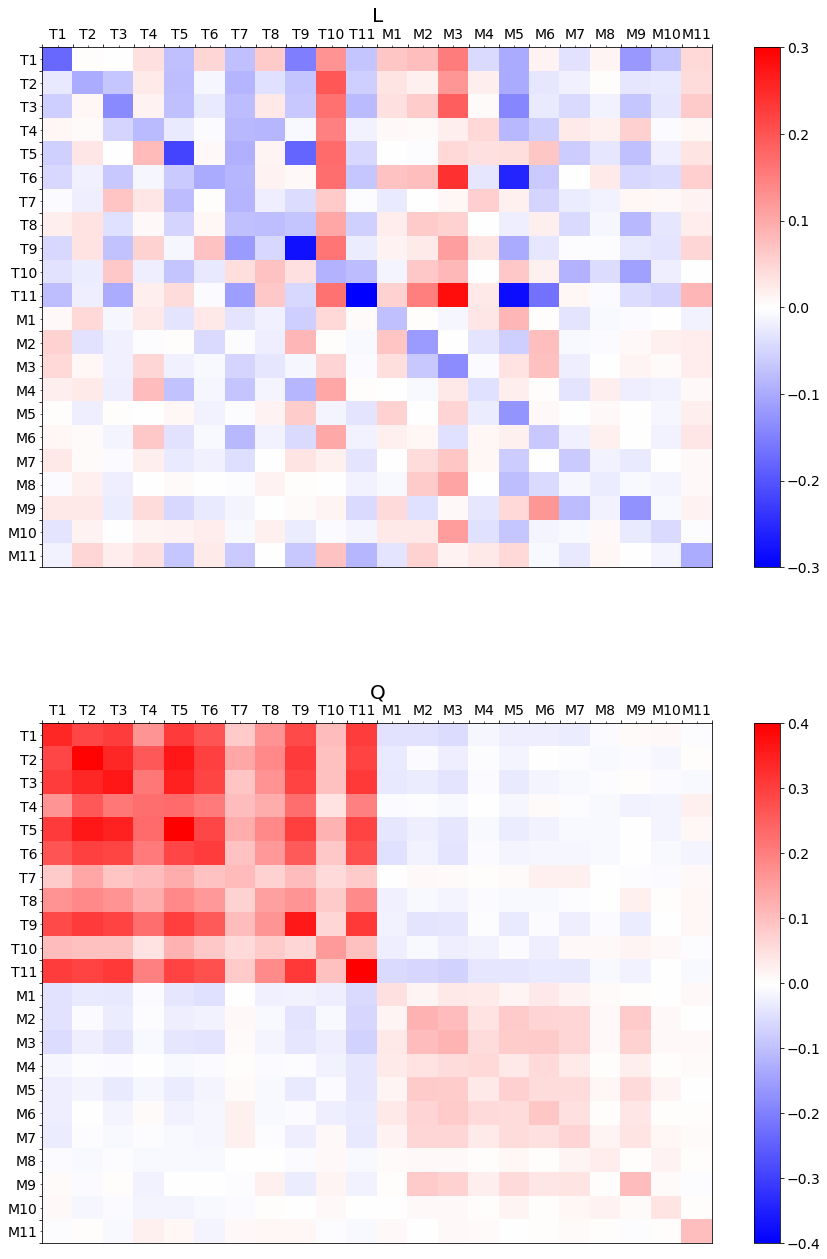

In [21]:
fig, axs = plt.subplots(2,1, figsize=(15, 22), facecolor='w', edgecolor='k')
ax1,ax2= axs.flatten()
fig.subplots_adjust(hspace = 0.3,wspace=0.3)

heatmap = ax1.pcolor(L.real,vmin=-0.3, vmax=0.3,cmap='bwr')       # MODIFY HERE to change data/colorbar range 
cbar=fig.colorbar(heatmap,ax=ax1)
cbar.ax.tick_params(labelsize=14)
ax1.set_title('L',fontsize=20)
#Make plot look more like a table
ax1.invert_yaxis()
ax1.xaxis.tick_top()
# Set up labels and tick marks - x axis
ax1.set_xticks(np.arange(nDat+1))
#        Hide major tick labels
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
#      Customize minor tick labels
ax1.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(nDat)+0.5))
ax1.xaxis.set_minor_formatter(ticker.FixedFormatter(stationIDs))
# Set up labels and tick marks - y axis
ax1.set_yticks(np.arange(nDat+1))
#      Hide major tick labels
ax1.yaxis.set_major_formatter(ticker.NullFormatter())
#      Customize minor tick labels
ax1.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(nDat)+0.5))
ax1.yaxis.set_minor_formatter(ticker.FixedFormatter(stationIDs))
ax1.tick_params(which='both',labelsize=14)

    
heatmap = ax2.pcolor(Q.real,vmin=-0.4, vmax=0.4,cmap='bwr')       # MODIFY HERE to change data/colorbar range 
cbar=fig.colorbar(heatmap,ax=ax2)
cbar.ax.tick_params(labelsize=14)
ax2.set_title('Q',fontsize=20)
#Make plot look more like a table
ax2.invert_yaxis()
ax2.xaxis.tick_top()
# Set up labels and tick marks - x axis
ax2.set_xticks(np.arange(nDat+1))
#      Hide major tick labels
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
#      Customize minor tick labels
ax2.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(nDat)+0.5))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(stationIDs))
# Set up labels and tick marks - y axis 
ax2.set_yticks(np.arange(nDat+1))
#      Hide major tick labels
ax2.yaxis.set_major_formatter(ticker.NullFormatter())
#      Customize minor tick labels
ax2.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(nDat)+0.5))
ax2.yaxis.set_minor_formatter(ticker.FixedFormatter(stationIDs))
ax2.tick_params(which='both',labelsize=14)

plt.show()


## 5. Tau test and Nyquist Mode check
- <font color='red'><b>This is an important section</b> for determining if the application of LIM is reasonable, or if there are any errors popping up. Errors will be marked with large warnings - do not procede if a warning is triggered; your lag needs to be reduced. </font> <br><br>
- This section uses a pre-defined script that computes LIM (contained in LIM_analysis.py and imported here).

In [22]:
# Define a series of different values of T0 to test over 

if tau0<=5:
    lags = np.arange(1,tau0+4,1) # Test lags from 1 to tau0+3 (need to give end point as +4 to get proper value)
else:
    lags = np.arange(tau0-4,tau0+4,1) # Test lags from tau0-3 to tau0+3
    

### 5.1 Check for nyquist modes 
- Nyquist modes arise when B.imag*Tau_0 is ~= pi


In [23]:
# Check each lag in lags array to see if/where a Nyquist mode arises 

for iLag in range(len(lags)): 
    b_alpha_fnct,L_fnct,Q_fnct,G_fnct,c0_fnct,cT_fnct,u_fnct,v_fnct,g_fnct,periods_fnct,decayT_fnct = LIM(data,lags[iLag]) #Compute LIM at this lag 
    nyq_check = b_alpha_fnct.imag*lags[iLag]    #Make array of beta_imaginary * lags, used to check for Nyquist mode 
    
    # Print out results of this check  for each lag 
    print('Tau_0 = ', lags[iLag])
    #print(nyq_check)     #For more information, you can print out the entire matrix of nyq_check for each tau0
    
    if (tau0==lags[iLag]): 
        print(' ** This is the tau0 you entered! **')
    
    if np.any((nyq_check>=3.141) & (nyq_check<=3.142))==True: 
        print('!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--')
        print('   WARNING: Nyquist mode encountered at this T0')
        print('!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--')  
        print('  Problem value of b_alpha.imag*T0 = ', nyq_check[np.where((nyq_check>=3.141) & (nyq_check<=3.142))])
        
    else: 
        print('No Nyquist mode here.')
    
    print()
        

/home/mfowler/Python/GitHub_Ready/LIM_analysis.py:117: RuntimeWarning: divide by zero encountered in true_divide
  periods = (2 * np.pi) / b_alpha.imag


Tau_0 =  3
No Nyquist mode here.

Tau_0 =  4
No Nyquist mode here.

Tau_0 =  5
No Nyquist mode here.

Tau_0 =  6
No Nyquist mode here.

Tau_0 =  7
 ** This is the tau0 you entered! **
No Nyquist mode here.

Tau_0 =  8
No Nyquist mode here.

Tau_0 =  9
!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--
!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--
  Problem value of b_alpha.imag*T0 =  [3.14159265]

Tau_0 =  10
!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--
!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--
  Problem value of b_alpha.imag*T0 =  [3.14159265]



#### 5.1.1 A second Nyquist mode test
Another test for the presence of a nyquist mode is to compare the error of hindcasts generated by the data when using various values of tau0. Ideally, the error should remain insensitive to the choice of tau used (as in the tau test), but if there is a Nyquist mode this may not be the case.
<br><br>
<i>Side note</i>: This section (computing hindcast error) is slow compared to the rest of the script. Recommend only running if other QC tests come back without issue and you suspect that something else is wrong with your data. 

In [25]:
# Define array of tau0 to test... 

#tau0_arr = np.arange(14)+1      # MODIFICATION: You may want to modify which tau0's are tested, as below. 
tau0_arr = np.asarray([2,5,7,8,9])

#   Create array of Tau's to get error at (out to 25 days)
Tau_arr      = np.arange(25)
    
meanErr_fcst_all = np.full([len(tau0_arr),nDat,len(Tau_arr)], np.nan)

#Get actual hindcast error at each tau0
for iT0 in range(len(tau0_arr)):
    
    #Run LIM script to get appropriate matrices for Tau0
    b_alpha_fnct,L_fnct,Q_fnct,G_fnct,c0_fnct,cT_fnct,u_fnct,v_fnct,g_fnct,periods_fnct,decayT_fnct = LIM(data,tau0_arr[iT0]) #Compute LIM at this lag 
    
    #Make diagonal matrix of g
    g_diag = np.zeros((np.shape(data)[0], np.shape(data)[0]), complex)
    np.fill_diagonal(g_diag, g_fnct)
    
    meanErr_fcst = np.full([nDat, len(Tau_arr)], np.nan) 
    
    #Loop over lead time array (Tau_arr)
    for iTau in range(len(Tau_arr)): 
        # Set up initial values as zero for time-averaged values 
        eps2_L = np.full([nDat],0.)
        ncor_L = np.full([nDat],0.)
        
        #Define Green function at this lag 
        G_tau    = np.dot(u_fnct,np.dot((g_diag)**(Tau_arr[iTau]/tau0_arr[iT0]),np.transpose(v_fnct))).real
        
        #Define empty array to store forecast at each time
        fcst     = np.full([nDat,nT-Tau_arr[iTau]], np.nan)
        
        for iT in range(nT-Tau_arr[iTau]):    #Loop over timesteps 
        
            # --- Get forecast data --- #
            #If there is any missing data at this time...
            if ( np.isnan(data[:,iT]).any() ): 
                #Indices where NaNs are *not*
                iNan = np.where(~np.isnan(data[:,iT]))

                #Make replica matrix replacing NaNs with zeros so that it won't count for other stations (but is computed)
                replZeros          = np.zeros(np.shape(data[:,iT]))
                replZeros[iNan[0]] = data[iNan[0],iT]

                #Get forecast using zeros array so that stations w/o NaN are still computed properly 
                fcst[:,iT] = np.dot(G_tau, replZeros)

                #Replacing stations that had missing data with a NaN (no forecast if no data)
                fcst[np.where(np.isnan(data[:,iT])),iT] = np.nan
            else:     
                #If no data is missing, just compute forecast as normal - G(Tau) * X(:,t)
                fcst[:,iT] = np.dot(G_tau, data[:,iT])

            # -- Build up mean squared error estimates for the LIM forecast at each station -- #
            for iSt in range(nDat):     #Loop over stations 
                # Make sure data exists
                if ( np.isfinite( data[iSt,iT] ) and np.isfinite( data[iSt,iT+Tau_arr[iTau]] ) ):     
                    fcst_Err    = data[iSt,iT+Tau_arr[iTau]] - fcst[iSt,iT]
                    eps2_L[iSt] = np.nansum([fcst_Err**2, eps2_L[iSt]])
                    ncor_L[iSt] = ncor_L[iSt] + 1

        # Compute mean squared error for every station over the period at this lag 
        meanErr_fcst[:,iTau]         = eps2_L/ncor_L 

    # Set first error estimate to zero: 
    meanErr_fcst[:,0]         = 0

    #Normalize by the variance at each station 
    for iSt in range(nDat):
        meanErr_fcst[iSt,:]   = meanErr_fcst[iSt,:]/np.nanvar(data[iSt,:])

    meanErr_fcst_all[iT0,:,:] = meanErr_fcst  #Should we take the trace of this array? 
        
    print('Done with iTau0 ', iT0)

Done with iTau0  0
Done with iTau0  1
Done with iTau0  2
Done with iTau0  3
Done with iTau0  4


(0, 1.1363634257667548)

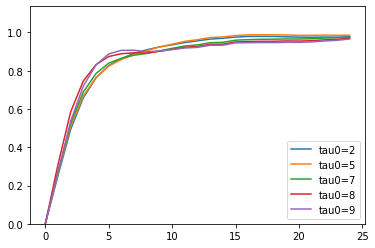

In [26]:
# Plot array of tau0 at iStation

iStation = 1   # choice of nDat index (if you want to look at just one)

#Plot hindcast error for all values of tau0 tested at this station 
for i in range(len(tau0_arr)):
    plt.plot(Tau_arr,meanErr_fcst_all[i,iStation,:],label='tau0='+str(tau0_arr[i]))
# Add legend and limit axis appropriately 
plt.legend()
plt.ylim([0,np.max(meanErr_fcst_all[:,iStation,:])*1.15])


(0, 0.9115889855862916)

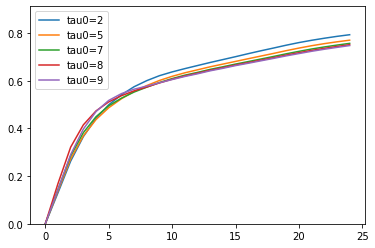

In [27]:
# Plot mean value of T0 at all stations 

for i in range(len(tau0_arr)):
    plt.plot(Tau_arr,np.nanmean(meanErr_fcst_all[i,:,:],axis=0),label='tau0='+str(tau0_arr[i]))

plt.legend()
plt.ylim([0,np.max(np.nanmean(meanErr_fcst_all,axis=1))*1.15])


### 5.2 Check eigenvalues of Q - should all be positive 
- This check is run with the tau0 explicitly requested by the user; won't be run for each choice of lag investigated otherwise in this section.

In [28]:
# Eigenanalysis of G 
Q_eigval,Q_eigvec = LA.eig(Q)

#Sort the eigenvalues in descending order 
iSortQ   = Q_eigval.argsort()[::-1]
Q_eigval = Q_eigval[iSortQ]
Q_eigvec = Q_eigvec[:,iSortQ]


In [29]:
if np.any(Q_eigval<0)==True: 
    print('!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--')
    print('        WARNING: Eigenvalue of Q is negative! ')
    print('!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--') 

### 5.3 Tau test 
- The results should be relatively insensitive to the choice of tau0 (with level agreement needed as determined by the user). 
- This will show the expected error, but that can be more formally plotted below in Section 8. 

In [30]:
# Error will be computed out to 31 days (assuming data is supplied in daily form)
tau_arr     = np.arange(32)


In [31]:
# Define expected error for range of lags defined in main part of Section 5 above. 

all_epsilon = np.full([len(lags),len(tau_arr)],np.nan)  #Empty array to store error in 

for iT0 in range(len(lags)):
    T0 = lags[iT0]
    
    #Carry out LIM with this value of lag
    b_alpha_fnct,L_fnct,Q_fnct,G_fnct,c0_fnct,cT_fnct,u_fnct,v_fnct,g_fnct,periods_fnct,decayT_fnct = LIM(data,T0)

    #Make diagonal matrix of g
    g_diag = np.zeros((np.shape(data)[0], np.shape(data)[0]), complex)
    np.fill_diagonal(g_diag, g_fnct)
    
    # Compute the Green function for various values of Tau given T0
    epsilon_tau = np.full([len(tau_arr)],np.nan)
    for iT in range(len(tau_arr)):
        G_tau           = np.dot(u_fnct,np.dot((g_diag)**(tau_arr[iT]/T0),np.transpose(v_fnct)))

        #Expected error 
        all_epsilon[iT0, iT] = (c0_fnct - np.dot(G_tau, np.dot(c0_fnct,np.transpose(G_tau)) ) ).trace()




/home/mfowler/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


**Plot the expected error** <br>
The tau test is passed if the results are not overly sensitive to the choice of tau0. So the lines plotted below should be close enough (with what determines 'close enough' determined by the user). 

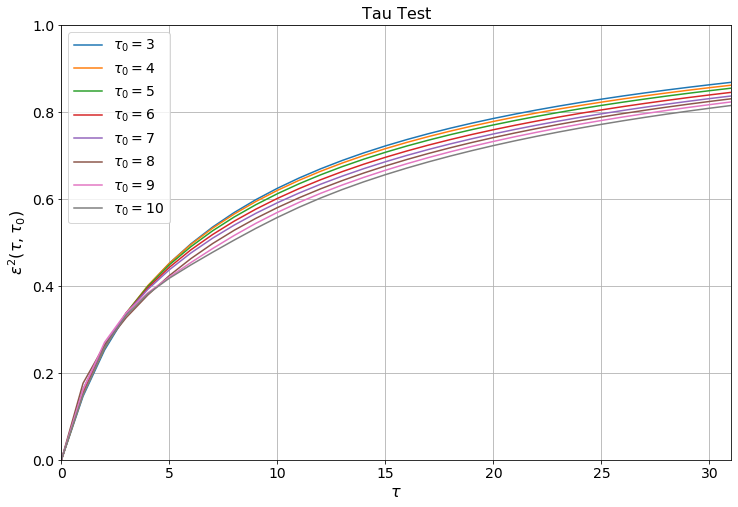

In [32]:
# Expected error on day 0, when conditions are known, is set to zero 
new_epsilon        = np.full([len(lags),len(tau_arr)],np.nan)
new_epsilon[:,0]   = 0                    
new_epsilon[:,1::] = all_epsilon[:,1::]

# Normalize by variance 
norm_epsilon = new_epsilon/np.nansum(np.nanvar(data,axis=1))

# Set up plot 
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)

# Plot each line for various choices of tau0 
for iT0 in range(len(lags)):
    ax1.plot(tau_arr, norm_epsilon[iT0,:],label = r'$\tau_{0} = $'+str(lags[iT0]))

ax1.set_xlabel(r'$\tau $',fontsize=16)
ax1.set_ylabel(r'$\epsilon^{2} (\tau , \tau_0 ) $',fontsize=16)
ax1.legend(fontsize=14)
ax1.set_title('Tau Test',fontsize=16)
ax1.set_xlim([0,31])
ax1.set_ylim([0,1])
ax1.tick_params(labelsize=14)
ax1.grid()


## 6. Maximum amplification curve
- The option is supplied to test a different value of tau0 if so desired, or can stick with original choice 

**User input allowed here**

In [33]:
switchT0 = input("Based on above results, would you like to change your choice of tau0? (y/n) ")
print()

if switchT0=='y': 
    #Redefine value of tau0 based on user input
    tau0 = int(input("What lag would you like to use to define the parameters of LIM? "))
    
    #Re-define LIM-based variables using this new value of tau0 
    b_alpha,L,Q,G,c0,cT,u,v,g,periods,decayT = LIM(data, tau0)
    
    print()


Based on above results, would you like to change your choice of tau0? (y/n) n



**Compute amplification used for plotting**

In [34]:
#Define range of days to determine amplification for 
tau_arr = np.arange(31)+1   #Start at day 1, not day 0 

gamma1  = np.full([len(tau_arr)],np.nan)  #Empty array to store leading eigenvalue in 

#Get diagonal matrix of g 
g_diag = np.zeros((np.shape(data)[0], np.shape(data)[0]), complex)
np.fill_diagonal(g_diag, g)

#Check G(tau) for each value in tau_arr given tau0 
for iLag in range(len(tau_arr)):
    G_tau = np.dot(u,np.dot((g_diag)**(tau_arr[iLag]/tau0),np.transpose(v)))

    # ---- EOF analysis of GtG ---- #
    GTG = np.dot(np.transpose(G_tau),G_tau)

    eigVal_GTG, eigVec_GTG = LA.eig(GTG)

    #Sort the eigenvalues in order 
    iSort_GTG  = eigVal_GTG.argsort()[::-1]   
    eigVal_GTG = eigVal_GTG[iSort_GTG]
    eigVec_GTG = eigVec_GTG[:,iSort_GTG]

    #Save first eigen value for this Tau (the maximum growing mode)
    gamma1[iLag] = np.log(eigVal_GTG[0])

#Insert a value of zero for day zero (initial conditions = no amplification)
gamma_all = np.insert(gamma1, 0, 0)


/home/mfowler/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


In [35]:
#Print out day with maximum amplification 
print('T0 =', tau0,' days; Peak growth = ',np.where(gamma_all==np.max(gamma_all))[0],' days')


T0 = 7  days; Peak growth =  [13]  days


In [36]:
# Define the lag associated with the maximum amplification (Tau_peak)
Tau_peak = int(np.where(gamma_all==np.max(gamma_all))[0])


**Plot the maximum amplification curve here**

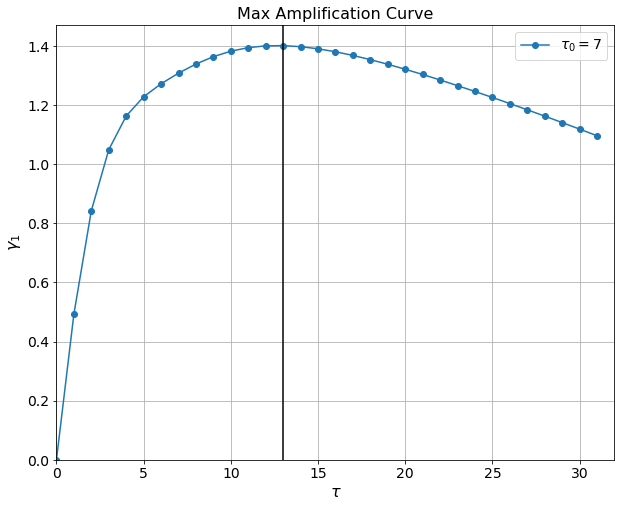

In [37]:
# Set up figure window 
fig, ax1  = plt.subplots()
fig.set_size_inches(10,8)

# Plot leading eigenvalue     
ax1.plot(np.arange(32),gamma_all,'o-')
ax1.set_xlim([0,32])
ax1.set_ylim([np.min(gamma_all)*1.05,np.max(gamma_all)*1.05])  #Extend to 5% above maximum value

ax1.set_xlabel(r'$\tau $',fontsize=16)
ax1.set_ylabel(r'$\gamma_1 $',fontsize=16)
ax1.grid()
ax1.axvline(Tau_peak,color='k')
ax1.set_title('Max Amplification Curve',fontsize=16)
ax1.legend([r'$\tau_0 = $'+str(tau0)],fontsize=14)
ax1.tick_params(labelsize=14)


## 7. Forecasts (hindcasts) based on input data
- Forecasts are made for a lead time of tau_peak
- The method below computes forecasts that can account for missing data 

In [38]:
#Get diagonal matrix of g (in case it wasn't done above)
g_diag = np.zeros((np.shape(data)[0], np.shape(data)[0]), complex)
np.fill_diagonal(g_diag, g)

#Now define the Green function at this lag (tau_peak)
G_tau    = np.dot(u,np.dot((g_diag)**(Tau_peak/tau0),np.transpose(v))).real


In [39]:
# Get the forecast in such a way as to account for missing dat a
fcst     = np.full([np.shape(data)[0],np.shape(data)[1]-Tau_peak], np.nan)

for iT in range(np.shape(data)[1]-Tau_peak):    #Loop over timesteps 

    # --- Get forecast data --- #
    #If there is any missing data at this time...
    if ( np.isnan(data[:,iT]).any() ): 
        #Indices where NaNs are *not*
        iNan = np.where(~np.isnan(data[:,iT]))

        #Make replica matrix replacing NaNs with zeros so that it won't count for other stations (but is computed)
        replZeros          = np.zeros(np.shape(data[:,iT]))
        replZeros[iNan[0]] = data[iNan[0],iT]

        #Get forecast using zeros array so that stations w/o NaN are still computed properly 
        fcst[:,iT] = np.dot(G_tau, replZeros)

        #Replacing stations that had missing data with a NaN (no forecast if no data)
        fcst[np.where(np.isnan(data[:,iT])),iT] = np.nan
    else:     
        #If no data is missing, just compute forecast as normal - G(Tau) * X(:,t)
        fcst[:,iT] = np.dot(G_tau, data[:,iT])



**As illustration, plot the timeseries of raw data at the first station alongside the forecast**

Text(0, 0.5, 'Magnitude')

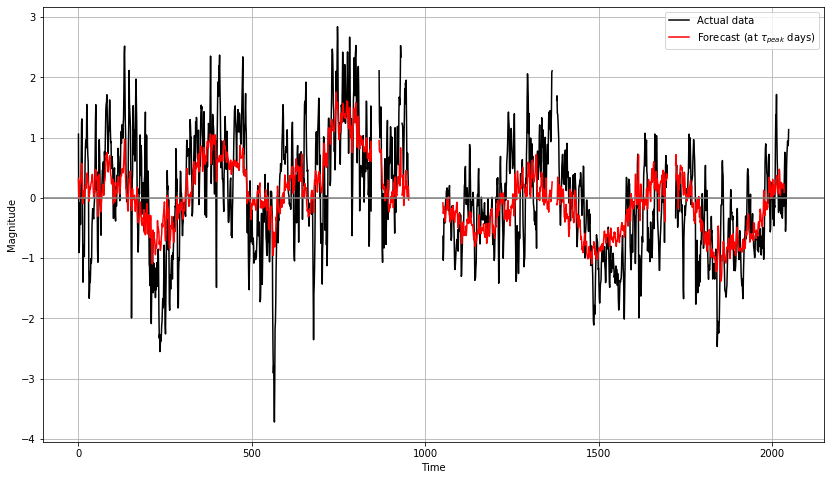

In [40]:
# Set up figure window 
fig, ax1  = plt.subplots()
fig.set_size_inches(14,8)

# Plot data 
ax1.plot(data[0,:],'k',label='Actual data')
ax1.plot(fcst[0,:],'r',label='Forecast (at '+ r'$\tau_{peak}$' +' days)')
ax1.axhline(0,color='gray')
ax1.grid()
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnitude')


## 8. Expected error 

In [41]:
# Define expected error for extended period 

#Lags to determine error over 
tau_arr = np.arange(75)

all_epsilon = np.full([len(tau_arr)],np.nan)  #Empty array to store error in 

#Make diagonal matrix of g
g_diag = np.zeros((np.shape(data)[0], np.shape(data)[0]), complex)
np.fill_diagonal(g_diag, g)

# Compute the Green function for various values of Tau given tau0
epsilon_tau = np.full([len(tau_arr)],np.nan)
for iT in range(len(tau_arr)):
    G_tau           = np.dot(u,np.dot((g_diag)**(tau_arr[iT]/tau0),np.transpose(v)))

    #Expected error 
    all_epsilon[iT] = (c0 - np.dot(G_tau, np.dot(c0,np.transpose(G_tau)) ) ).trace()


/home/mfowler/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


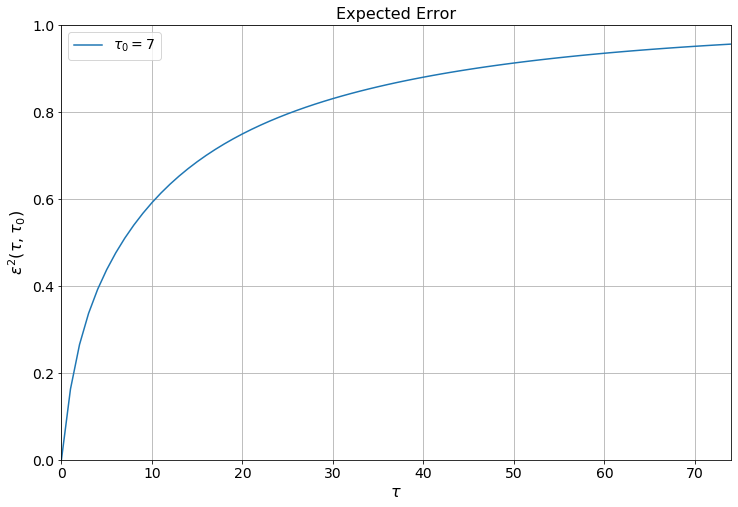

In [42]:
# Expected error on day 0, when conditions are known, is set to zero 
new_epsilon      = np.full([len(tau_arr)],np.nan)
new_epsilon[0]   = 0                    
new_epsilon[1::] = all_epsilon[1::]

# Normalize by variance 
norm_epsilon = new_epsilon/np.nansum(np.nanvar(data,axis=1))

# Set up plot 
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)

#Plot expected error 
ax1.plot(tau_arr, norm_epsilon,label = r'$\tau_{0} = $'+str(tau0))

ax1.set_xlabel(r'$\tau $',fontsize=16)
ax1.set_ylabel(r'$\epsilon^{2} (\tau , \tau_0 ) $',fontsize=16)
ax1.legend(fontsize=14)
ax1.set_title('Expected Error',fontsize=16)
ax1.set_xlim([0,max(tau_arr)])
ax1.set_ylim([0,1])
#ax1.set_ylim([0,np.max(new_epsilon)+(0.05*np.max(new_epsilon))])
ax1.tick_params(labelsize=14)
ax1.grid()


## 9. Optimal structure 

In [43]:
#Make diagonal matrix of g (again, if not done before)
g_diag = np.zeros((np.shape(data)[0], np.shape(data)[0]), complex)
np.fill_diagonal(g_diag, g)

#Define Green's function at the peak of the max amplification growth
G_tau           = np.dot(u,np.dot((g_diag)**(Tau_peak/tau0),np.transpose(v)))

# ---- EOF analysis of GtG ---- #
GTG = np.dot(np.transpose(G_tau),G_tau)

eigVal_GTG, eigVec_GTG = LA.eig(GTG)

#Sort the eigenvalues in order 
iSort_GTG  = eigVal_GTG.argsort()[::-1]   
eigVal_GTG = eigVal_GTG[iSort_GTG] 
eigVec_GTG = eigVec_GTG[:,iSort_GTG]

#The optimal structure is the first eigenVector of the matrix GtG. 
optimStruct = eigVec_GTG[:,0].real

#Get the forecast by projecting G(tau) onto that optimal structure 
forecast = np.dot(G_tau.real,optimStruct)


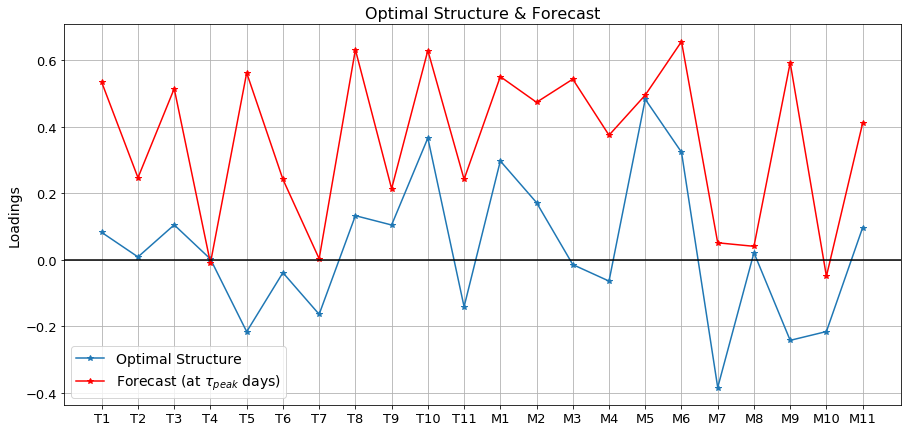

In [44]:
# Make plot of the optimal structure and the forecast 
fig, ax1  = plt.subplots()
fig.set_size_inches(15,7)

nStations        = np.arange(nDat)

# --- EOF 1 --- #
ax1.plot(nStations,optimStruct,'*-')
ax1.plot(nStations,forecast,'r*-')
ax1.set_xticks(nStations)
ax1.set_xticklabels(stationIDs)
ax1.tick_params(labelsize=13)
ax1.set_ylabel('Loadings',fontsize=14)
ax1.grid()
ax1.set_title('Optimal Structure & Forecast',fontsize=16)
ax1.legend(['Optimal Structure','Forecast (at '+ r'$\tau_{peak}$' +' days)'],fontsize=14)
ax1.axhline(0, color='black')



## 10. Mode analysis 

### 10.1 Get periods and decay times of modes

In [45]:
# First, define the periods and decay times of the modes 
periods = (2*np.pi)/b_alpha.imag
decayT = -1/b_alpha.real


/home/mfowler/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [46]:
print('             *** Lag:  ', tau0, ' days ***')
print('      Alpha          Period         Decay Time  ')
print('     ---------    ------------     ------------  ')
for iS in range(nDat):
    print('%12i %14.3f %17.3f' % (iS, periods[iS],decayT[iS]))
print()



             *** Lag:   7  days ***
      Alpha          Period         Decay Time  
     ---------    ------------     ------------  
           0            inf           121.147
           1       1027.791            49.010
           2      -1027.791            49.010
           3        430.284            44.686
           4       -430.284            44.686
           5        763.833            22.189
           6       -763.833            22.189
           7        308.427            16.942
           8       -308.427            16.942
           9            inf            14.485
          10            inf             9.961
          11        178.428             9.124
          12       -178.428             9.124
          13        135.566             8.745
          14       -135.566             8.745
          15         77.041             6.025
          16        -77.041             6.025
          17            inf             5.470
          18        237.216          

### 10.2 Get time series and variance of each mode

In [47]:
# Compute z while allowing for NaNs...
z = np.zeros([len(u),len(data[0,:])],complex)  #Timeseries of modes (z)

# Get variance in each mode
varMode = np.zeros([len(u)])

v_tr = np.transpose(v)  #Get transpose of v 

for iMd in range(len(u)):                #Loop over modes 
    for iT in range(len(data[0,:])):     #Loop over length of time in record 
        for iSt in range(len(u)):        #Loop over station 
            
            z[iMd,iT]    += np.nansum(v_tr[iMd,iSt] * data[iSt,iT])  #Compute z, the timeseries of the mode 
            
        #Get the variance of the mode 
        varMode[iMd] += np.nansum([(z[iMd,iT].real**2), (z[iMd,iT].imag**2)])
        
    varMode[iMd] = varMode[iMd]/len(data[0,:])


In [48]:
# Add variance of each mode to the table above 

print('                       *** Lag:  ', tau0, ' days ***')
print('      Alpha          Period          Decay Time      var(mode)')
print('     ---------    ------------     ------------     ------------')
for iS in range(nDat):
    print('%12i %14.3f %17.3f %15.3f' % (iS, periods[iS],decayT[iS], varMode[iS]))
print()


                       *** Lag:   7  days ***
      Alpha          Period          Decay Time      var(mode)
     ---------    ------------     ------------     ------------
           0            inf           121.147           0.390
           1       1027.791            49.010           0.409
           2      -1027.791            49.010           0.409
           3        430.284            44.686           0.297
           4       -430.284            44.686           0.297
           5        763.833            22.189           0.185
           6       -763.833            22.189           0.185
           7        308.427            16.942           0.129
           8       -308.427            16.942           0.129
           9            inf            14.485           0.197
          10            inf             9.961           0.262
          11        178.428             9.124           0.139
          12       -178.428             9.124           0.139
          13        

## 11. (Optional) Apply a different normalization to G(tau) 
- In the case of the manuscript, Fowler and Penland (2020; in prep), we applied not only a field norm as above, but also a moisture norm to emphasize the prediction of that portion of data. 
- To apply a similar norm, modify a weight matrix below to select the portion of G(tau) you want to focus on. For example, in our case moisture is in the bottom half of the matrix, so we supply a weight matrix that has the same dimensions as G(tau), but has zeros on the top half and ones on the bottom half diagonal elements. 

In [76]:
#Define a weight matrix that is the same size as G 
wgtMatrix = np.zeros([nDat,nDat])

# -- MODIFY HERE -- # 
for i in range(11):          # For the moisture norm, we only want to consider the bottom half of G. 
    wgtMatrix[i+11,i+11]=1   # So the weight matrix should be 1s on diagonal in bottom half



In [77]:
print('This is your weight matrix: ')
print()
print(wgtMatrix)

This is your weight matrix: 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0.

### 11.1 Maximum amplification curve

In [78]:
#Define range of days to determine amplification for 
tau_arr = np.arange(31)+1   #Start at day 1, not day 0 

gamma1  = np.full([len(tau_arr)],np.nan)  #Empty array to store leading eigenvalue in 

#Get diagonal matrix of g 
g_diag = np.zeros((np.shape(data)[0], np.shape(data)[0]), complex)
np.fill_diagonal(g_diag, g)

#Check G(tau) for each value in tau_arr given tau0 
for iLag in range(len(tau_arr)):
    G_tau = np.dot(u,np.dot((g_diag)**(tau_arr[iLag]/tau0),np.transpose(v)))
    G_m             = G_tau[11:22,:]  #The bottom half of the array contains moisture information 

    # ---- EOF analysis of GtG ---- #
    #GTG = np.dot(np.transpose(G_m),G_m)
    GTG = np.dot(np.transpose(G_tau), np.dot(wgtMatrix, G_tau))
    
    eigVal_GTG, eigVec_GTG = LA.eig(GTG)

    #Sort the eigenvalues in order 
    iSort_GTG  = eigVal_GTG.argsort()[::-1]   
    eigVal_GTG = eigVal_GTG[iSort_GTG]
    eigVec_GTG = eigVec_GTG[:,iSort_GTG]

    #Save first eigen value for this Tau (the maximum growing mode)
    gamma1[iLag] = np.log(eigVal_GTG[0])

#Insert a value of zero for day zero (initial conditions = no amplification)
gamma_all = np.insert(gamma1, 0, 0)



/home/mfowler/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


In [79]:
#Print out day with maximum amplification 
print('T0 =', tau0,' days; Peak growth = ',np.where(gamma_all==np.max(gamma_all))[0],' days')


T0 = 7  days; Peak growth =  [16]  days


In [80]:
# Define the lag associated with the maximum amplification (Tau_peak)
Tau_peak = int(np.where(gamma_all==np.max(gamma_all))[0])


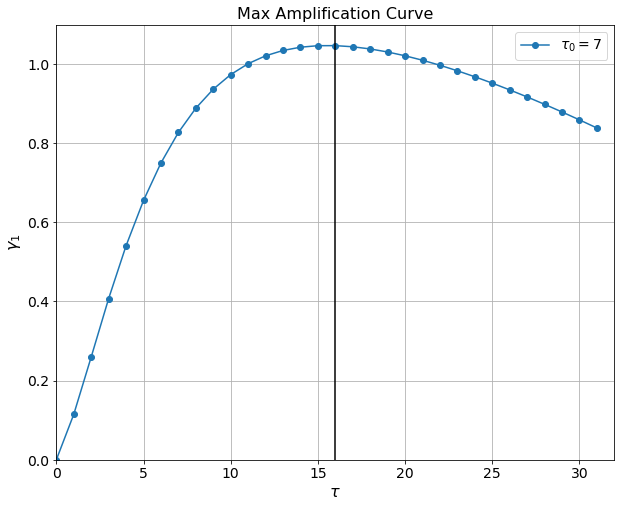

In [81]:
# Set up figure window 
fig, ax1  = plt.subplots()
fig.set_size_inches(10,8)

# Plot leading eigenvalue     
ax1.plot(np.arange(32),gamma_all,'o-')
ax1.set_xlim([0,32])
ax1.set_ylim([0,np.max(gamma_all)*1.05])  #Extend to 5% above maximum value

ax1.set_xlabel(r'$\tau $',fontsize=16)
ax1.set_ylabel(r'$\gamma_1 $',fontsize=16)
ax1.grid()
ax1.axvline(Tau_peak,color='k')
ax1.set_title('Max Amplification Curve',fontsize=16)
ax1.legend([r'$\tau_0 = $'+str(tau0)],fontsize=14)
ax1.tick_params(labelsize=14)



### 11.2 Get the optimal structure associated with this norm

In [82]:
#Initial conditions/definitions from LIM 

G_tau           = np.dot(u,np.dot((g_diag)**(Tau_peak/tau0),np.transpose(v)))  #Peak growth now at 16 days 
G_m             = G_tau[11:22,:]

# ---- EOF analysis of GtG ---- #
matr = np.dot(np.transpose(G_m),G_m)

eigVal_GTG, eigVec_GTG = LA.eig(matr)

#Sort the eigenvalues in order 
iSort_GTG  = eigVal_GTG.argsort()[::-1]   
eigVal_GTG = eigVal_GTG[iSort_GTG] 
eigVec_GTG = eigVec_GTG[:,iSort_GTG]

#The optimal strcture based on the moisture norm version of GtG 
optimStruct = eigVec_GTG[:,0].real

#Get forecast by projecting the mositure optimal structure onto the original G(tau)
forecast = np.dot(G_tau.real,optimStruct)


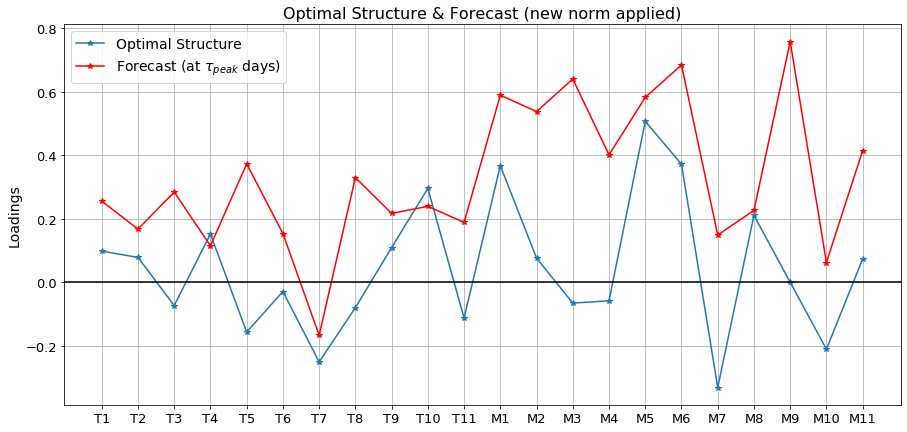

In [83]:
# Make plot of the optimal structure and the forecast 
fig, ax1  = plt.subplots()
fig.set_size_inches(15,7)

nStations        = np.arange(nDat)

# --- EOF 1 --- #
ax1.plot(nStations,optimStruct,'*-')
ax1.plot(nStations,forecast,'r*-')
ax1.set_xticks(nStations)
ax1.set_xticklabels(stationIDs)
ax1.tick_params(labelsize=13)
ax1.set_ylabel('Loadings',fontsize=14)
ax1.grid()
ax1.set_title('Optimal Structure & Forecast (new norm applied)',fontsize=16)
ax1.legend(['Optimal Structure','Forecast (at '+ r'$\tau_{peak}$' +' days)'],fontsize=14)
ax1.axhline(0, color='black')
